<a href="https://colab.research.google.com/github/LivingstonTardzenyuy/Deep-Learning-with-TensorFlow/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-tuning.

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: **fine-tuning**

In [5]:
# Check if we're using a GPU.
!nvidia-smi

Mon Dec 23 01:52:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, howerver, this is tedious

# Let's get some data.

This time we're going to see how we can use the pretrained models withing tf.keras.applications and apply them to our own problem (recognizing images of food).

Link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [6]:
# Function to unzip our data.
def unzip_data(filename):
  """
    Unzips filename into current working directory.

  Args:
    filename (str): a zip file path.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [7]:
import zipfile
import os
# Get 10% of training data of 10 classes of Food101.

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-12-23 01:52:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.207, 172.217.218.207, 142.251.31.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.5’

10_food_classes_10_ 100%[===================>] 160.74M  40.8MB/s    in 4.6s    

2024-12-23 01:52:21 (35.3 MB/s) - ‘10_food_classes_10_percent.zip.5’ saved [168546183/168546183]



In [8]:
# Get 10 percent
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}")


walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent
There are 10 directories and 0 images in '10_food_classes_10_percent/train
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream
There are

In [9]:
 # Create a training and test directory path.
 train_path = "10_food_classes_10_percent/train"
 test_path = "10_food_classes_10_percent/test"

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = image_dataset_from_directory(directory =train_path, image_size = IMG_SIZE, label_mode = "categorical", batch_size= BATCH_SIZE)
test_data = image_dataset_from_directory(directory = test_path, image_size = IMG_SIZE, label_mode = "categorical", batch_size= BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [11]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [12]:
# Check out the class names of our dataset.
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [13]:
# See an example of a batch of data.
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[3.50000000e+01 1.50000000e+01 6.00000000e+00]
   [3.46683655e+01 1.46683674e+01 5.66836739e+00]
   [3.40000000e+01 1.40000000e+01 5.42857170e+00]
   ...
   [6.00000000e+00 6.00000000e+00 4.00000000e+00]
   [6.00000000e+00 6.00000000e+00 6.00000000e+00]
   [6.35717773e+00 6.35717773e+00 6.35717773e+00]]

  [[3.69285736e+01 1.69285717e+01 7.92857170e+00]
   [3.60000000e+01 1.60000000e+01 7.00000000e+00]
   [3.59285736e+01 1.59285717e+01 7.35714340e+00]
   ...
   [6.00000000e+00 6.00000000e+00 4.00000000e+00]
   [6.00000000e+00 6.00000000e+00 6.00000000e+00]
   [6.35717773e+00 6.35717773e+00 6.35717773e+00]]

  [[3.67857132e+01 1.67857132e+01 7.35714245e+00]
   [3.60561218e+01 1.60561218e+01 6.62755060e+00]
   [3.60000000e+01 1.60000000e+01 7.00000000e+00]
   ...
   [6.00000000e+00 6.00000000e+00 4.00000000e+00]
   [6.00000000e+00 6.00000000e+00 6.00000000e+00]
   [6.35717773e+00 6.35717773e+00 6.35717773e+00]]

  ...

  [[2.67193794e+01 1.77193794e+01 1.27193804e+01]
   [2

## Model 0: Building a transfer learning model using the Keras Functional API.

The sequential API is straight-forward, it runs our layers in sequential order.

But the Functional API gives flexibility with our model.

In [14]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [15]:
# 1. Create the base model with tf.keras.application.

base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,     # because we want to include our own layer.
    )

# 2. Freeze the base model (so the underlying pre-trained patterns areint' updated)
base_model.trainable = False   # don't train yet.

# 3. Create inputs into our model.
inputs = tf.keras.layers.Input(shape=(224,224,3), name = 'input_layer')

# 4. If using ResNet50V2 you will need to normalize inputs.
# x = tf.keras.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model.
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the data model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)
print(f"Shape after Global Average Pooling: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name = 'output_layer')(x)

# 8. Combine the inputs with the outputs into a model.
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile for the model.
model_0.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)


#10. Fit the model.
history_0 = model_0.fit(
    train_data_10_percent,
    epochs = 5,
    steps_per_epoch = len(train_data_10_percent),
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [
        create_tensorboard_callback(dir_name = "transfer_learning",
                                    experiment_name = "model_0_transfer_learning")
    ]
)

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after Global Average Pooling: (None, 1280)
Saving TensorBoard log files to: transfer_learning/model_0_transfer_learning/20241223-015233
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.2313 - loss: 2.2016 - val_accuracy: 0.6876 - val_loss: 1.4046
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/5
 1/24 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.7188 - loss: 1.4084

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 298ms/step - accuracy: 0.7192 - loss: 1.2724 - val_accuracy: 0.7896 - val_loss: 0.9680
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 301ms/step - accuracy: 0.7947 - loss: 0.9071 - val_accuracy: 0.8136 - val_loss: 0.7915


In [16]:
# Evaluate the full test dataset.

model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8136 - loss: 0.7776


[0.7915429472923279, 0.8136000037193298]

In [17]:
# Different type of layers.
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_layer
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [18]:
base_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, None, None, 3)  │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, None, None, 3)  │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, None, None, 3)  │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, None, None, 32) │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, None, None, 32) │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, None, None, 32) │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, None, None, 32) │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, None, None, 32) │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, None, None, 32) │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

## Getting a feature vector from a trained moel.

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through 'base_model' of shape (None, 7,7, 1280)...

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D

In [19]:
# Define the input shape.
import tensorflow as tf

input_shape = (1,4,4,3)

# Create a random tensor.
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer.
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D gloabl average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors.
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of global average pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D gloabl average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of global average pooled 2D tensor: (1, 3)


In [20]:
# Let's use 'GlobalMaxPool2D' ...

input_shape = (1,4,4,3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)


# Check the shape of the different tensors.
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of global average pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

Shape of input tensor: (1, 4, 4, 3)
Shape of global average pooled 2D tensor: (1, 3)


## Running a series of transfer learning experiments.

We've seen the great result transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data.... how about we setup a bunch of experiments to find out:

1. 'model_1' - use feature extraction transfer learning with 1% of the training data with data augmentation.

2. 'model_2' - use feature extraction transfer learning with 10% of the training with data augmentation.

3. 'model_3' - use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. 'model_4' - use fine-tuning transferl earning with data augmentation with 100% of data.

**Note:** Throughout all experiments the same test dataset will be used to evlulate our model... this ensures consistency across evalution metrics.

In [21]:
# Download and unzip data - preprocessed from Food101.

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2024-12-23 01:53:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.207, 108.177.127.207, 172.217.218.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.5’

10_food_classes_1_p 100%[===================>] 127.42M  37.5MB/s    in 3.8s    

2024-12-23 01:53:57 (33.9 MB/s) - ‘10_food_classes_1_percent.zip.5’ saved [133612354/133612354]



In [22]:
# Create training and test dirs.

train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [23]:
# How many images are we working with ?.
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent
There are 10 directories and 0 images in '10_food_classes_1_percent/train
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream
There are 10 directories and 0 

In [24]:
# Setup data loaders
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_1_percent = image_dataset_from_directory(directory = train_dir_1_percent,
                                                    label_mode = "categorical",
                                                    image_size = IMG_SIZE,
                                                    batch_size = BATCH_SIZE
                                                    )

test_data = image_dataset_from_directory(directory = test_dir,
                                          label_mode = "categorical",
                                          image_size = IMG_SIZE,
                                          batch_size = BATCH_SIZE
                                          )

#

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentaiton righ into the model.

To add data augmenation right into our models, we can use the layers inside:

* tf.keras.layers.experimental.preprocessing()

In [25]:
from tensorflow import keras
from tensorflow.keras import layers

def apply_augmentation(img):
  img = layers.RandomFlip('horizontal')(img)
  img = layers.RandomRotation(0.2)(img)
  img = layers.RandomZoom(0.2)(img)
  img = layers.RandomHeight(0.2)(img)
  img =layers.RandomWidth(0.2)(img)
  return img

### Visualize our data augmentation layer(and see what happens to our data)

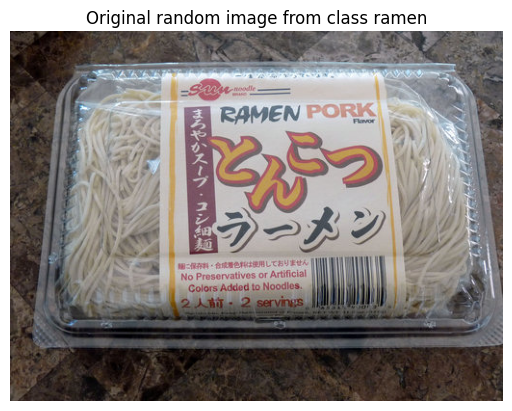

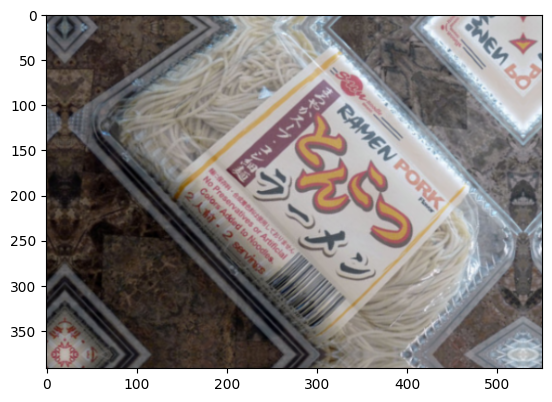

In [26]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot in the random image.
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False);

# Now let's plot our augmented random image.
img = tf.image.resize(img, size=[384, 512])
img = tf.cast(img, dtype=tf.float32)
augmented_img = apply_augmentation(img)  # Apply data augmentation

# Normalize pixel values to [0, 1]
augmented_img = augmented_img / 255.0

plt.figure()
plt.imshow(augmented_img)  # Now you can plot the image using matplotlib

## Model 1. Feature Extraction Transfer Learning on 1% of the data with *Data Augmentation*

In [27]:
# Setup input shape and base model, freezing the base model layers.

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(
    include_top = False
)

base_model.trainable = False

# Create input layer.
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer.
x = apply_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it.
x = base_model(x, training=False)

# Pool out features of the base model.
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make the model using inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model.
model_1.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)


# Fit the model.
history_1_percent = model_1.fit(
    train_data_1_percent.repeat(),
    epochs = 5,
    steps_per_epoch = len(train_data_1_percent),
    validation_data = test_data,
    validation_steps = int(0.25 * len(test_data)),
    callbacks = [
        create_tensorboard_callback(dir_name = "transfer_learning",
                                    experiment_name = "model_1_transfer_learning")
    ]
)

Saving TensorBoard log files to: transfer_learning/model_1_transfer_learning/20241223-015402
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.1339 - loss: 2.3327 - val_accuracy: 0.1924 - val_loss: 2.1966
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 993ms/step - accuracy: 0.2379 - loss: 2.1256 - val_accuracy: 0.2681 - val_loss: 2.0904
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 839ms/step - accuracy: 0.3316 - loss: 2.0374 - val_accuracy: 0.3372 - val_loss: 2.0342
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 703ms/step - accuracy: 0.5598 - loss: 1.8174 - val_accuracy: 0.3405 - val_loss: 1.9660
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step - accuracy: 0.5624 - loss: 1.6878 - val_accuracy: 0.3382 - val_loss: 1.9870


In [28]:
model_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_1 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_1 (RandomZoom)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_height_1 (RandomHeight)       │ (None, None, 224, 3)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_width_1 (RandomWidth)         │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,088,003 (15.59 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 25,622 (100.09 KB)

In [29]:
# evaluate on the full test data.
results_1_percent_data_aug = model_1.evaluate(test_data)

results_1_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.4442 - loss: 1.8402


[1.863517165184021, 0.42320001125335693]

In [30]:
# How does model go with Data Augmentation ?.

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

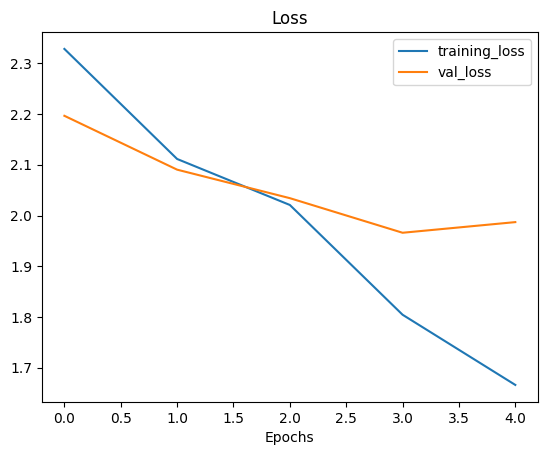

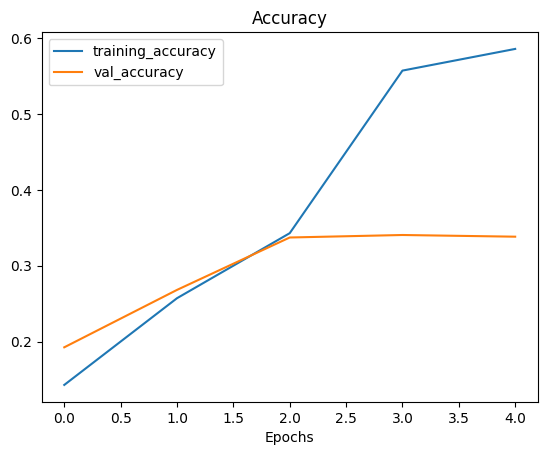

In [31]:
plot_loss_curves(history_1_percent)

## Model 2. Feature Extraction Transfer Learning on 10% of the data adding Data Augmentation as a Layer.

In [32]:
# Setting up training and test directories.

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [33]:
# Set data inputs.
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir_10_percent,
    label_mode = "categorical",
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    label_mode = "categorical",
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [34]:
# Create model 2 with data augmentation build in.
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


# Build data augmentation layer.
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # layers.Rescaling(1./255) No need to include it here bcause the rescaling is already build into EfficientNet.
], name="data_augmentation")


# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(
    include_top = False
)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
imputs = layers.Input(shape = (224,224,3), name = "input_layer")
x = data_augmentation(inputs)  # Augment our training data
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode,
x = layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)  # GlobalAVeragePooling2D takes a multi-dimensional array and returns only (x,y)
outputs = layers.Dense(10, activation='softmax', name = 'output_layer')(x)

# Create model 2.
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model.
model_2.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)


### Creating a model checkpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we come back and start where we left.

In [35]:
# Set checkpoint filepath
checkpoint_filepath = "ten_percent_model_checkpoints_weight/checkpoint.keras"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [36]:
initial_epoch_value = 10

In [37]:
# Fit the model
history_model_2_10_percent_data_aug = model_2.fit(
    train_data_10_percent.repeat(),
    epochs = initial_epoch_value,
    steps_per_epoch = len(train_data_10_percent),
    validation_data = test_data,
    validation_steps = int(0.25 * len(test_data)),
    callbacks = [model_checkpoint_callback, # Pass the ModelCheckpoint instance directly
                create_tensorboard_callback( # Use create_tensorboard_callback for TensorBoard logging
                    dir_name="transfer_learning",
                    experiment_name="model_2_transfer_learning_data_aug"
                )
               ]
)

Saving TensorBoard log files to: transfer_learning/model_2_transfer_learning_data_aug/20241223-015439
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 305ms/step - accuracy: 0.1669 - loss: 2.2312 - val_accuracy: 0.6118 - val_loss: 1.5501
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.5641 - loss: 1.5778 - val_accuracy: 0.6891 - val_loss: 1.1583
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 0.6736 - loss: 1.2395 - val_accuracy: 0.7599 - val_loss: 0.9801
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 244ms/step - accuracy: 0.7421 - loss: 1.0166 - val_accuracy: 0.7878 - val_loss: 0.8394
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.7543 - loss: 0.9210 - val_accuracy: 0.8088 - val_loss: 0.7763
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.7536 - loss: 0.8660 - val_accuracy: 0.8355 - val_loss: 0.6790
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.8035 - loss: 0.7854 - val_accuracy: 0.7697 - val_loss: 0.7161
E

In [38]:
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.8216 - loss: 0.7994


[0.7915430068969727, 0.8136000037193298]

In [39]:
 model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.8278 - loss: 0.6159


[0.633277416229248, 0.8131999969482422]

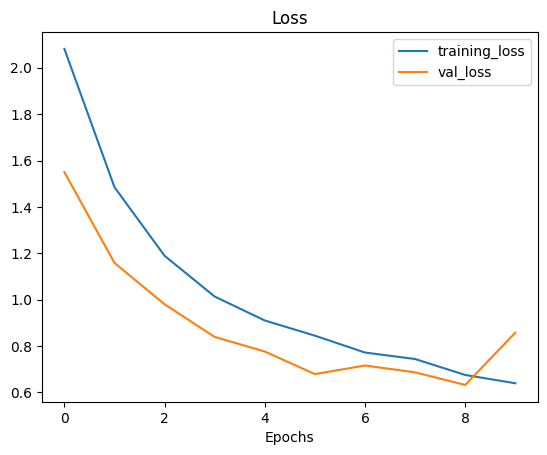

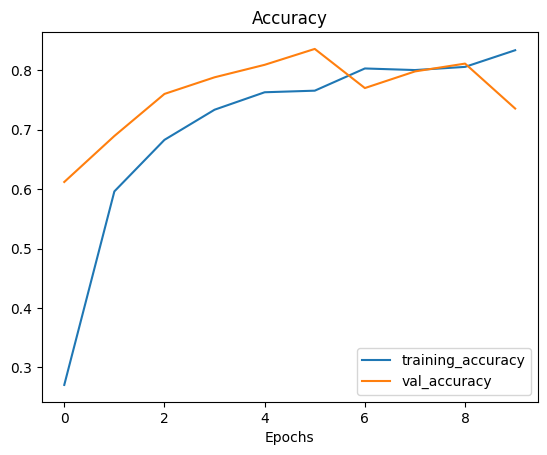

In [40]:
# Plot model loss curves
plot_loss_curves(history_model_2_10_percent_data_aug)

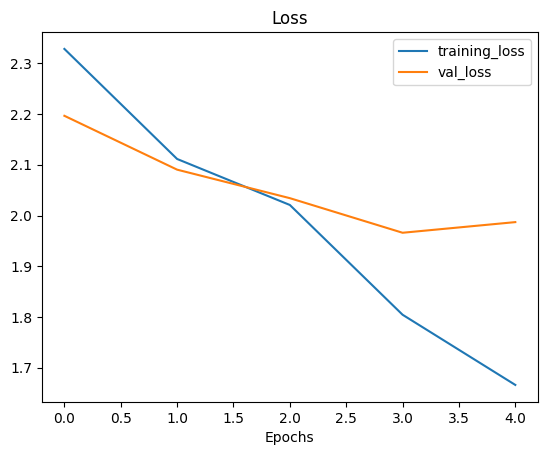

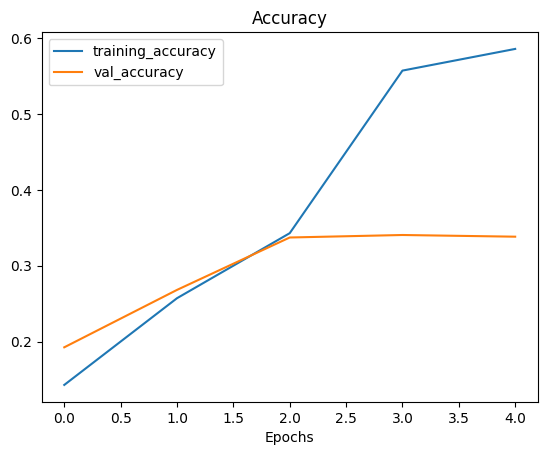

In [41]:
plot_loss_curves(history_1_percent)

## Loading in checkpointed weights.

Loading it checkpointed weights returns a model to a specific checkpoint.

In [42]:
# Load in aved model weights and evaluate model.

model_2.load_weights(checkpoint_filepath)

In [43]:
# evaluate model_2 with loaded weights.
model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.8163 - loss: 0.7024


[0.7249845862388611, 0.800000011920929]

In [44]:
# If results from our previously evaluated model_2 match the loaded weights, everything has worked!
model_2.load_weights(checkpoint_filepath) == model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.8099 - loss: 0.7179


False

## Model 3: fine-tuning an existing model with 10% of the data

**Note**: Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [45]:
# Layers in loaded model.

model_2.layers

[<InputLayer name=input_layer, built=True>,
 <Sequential name=data_augmentation, built=True>,
 <Functional name=efficientnetb0, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling_layer, built=True>,
 <Dense name=output_layer, built=True>]

In [46]:
# Are these layers trainable ?.
for layer in model_2.layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> True
<Sequential name=data_augmentation, built=True> True
<Functional name=efficientnetb0, built=True> False
<GlobalAveragePooling2D name=global_average_pooling_layer, built=True> True
<Dense name=output_layer, built=True> True


In [47]:
# What layers in our base model and are they trainable..
for i,layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_layer_2 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [48]:
# How many trainable variables are in our base model ?.
print(len(model_2.layers[2].trainable_variables))

0


In [49]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True

base_model.trainable = True

# Freeze all layers except for last 10.
for layer in base_model.layers[:-10]:
  layer.trainable = False


# Recompile (we have to recompile our models every time we make a change)
model_2.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),   # When fine-tuning we lower the learning rate by 10x
    metrics = ['accuracy']
)


In [50]:
# Check which layers are trainable (tunable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer_2 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [51]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variable...

print(len(model_2.trainable_variables))

12


In [52]:
# Fine-tune for another 5 epocs. Know that the model we have was already trained.

fine_tune_epochs = 10 + 5   # The 10 was our initial_epochs then we've added 5 to it.

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(
    train_data_10_percent,
    epochs = fine_tune_epochs,
    validation_data = test_data,
    validation_steps = int(0.25 * len(test_data)),
    initial_epoch = history_model_2_10_percent_data_aug.epoch[-1],   # We want to start from where we left off since we already started
    callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                             experiment_name="10_percent_fine_tune_last")]
)

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last/20241223-015648
Epoch 10/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 303ms/step - accuracy: 0.8048 - loss: 0.8099 - val_accuracy: 0.8207 - val_loss: 0.6560
Epoch 11/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.8215 - loss: 0.7324 - val_accuracy: 0.8257 - val_loss: 0.5646
Epoch 12/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.8419 - loss: 0.6211 - val_accuracy: 0.8109 - val_loss: 0.5953
Epoch 13/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - accuracy: 0.8806 - loss: 0.5185 - val_accuracy: 0.8454 - val_loss: 0.5066
Epoch 14/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 817ms/step - accuracy: 0.8751 - loss: 0.5162 - val_accuracy: 0.8529 - val_loss: 0.4905
Epoch 15/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.8726 - loss: 0.5015 - val_accuracy: 0.8783 - val_loss: 0.3967


In [53]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)
results_fine_tune_10_percent

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.8610 - loss: 0.4402


[0.4618600606918335, 0.8515999913215637]

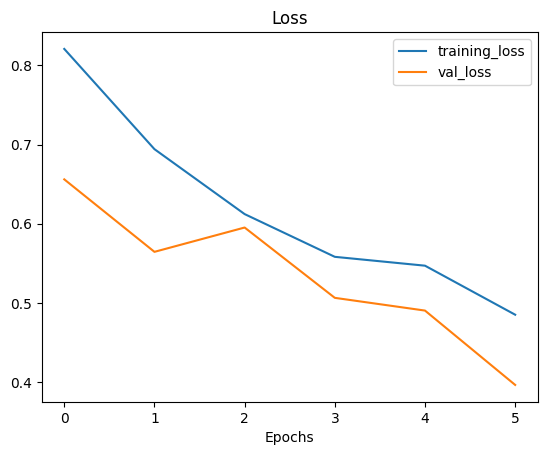

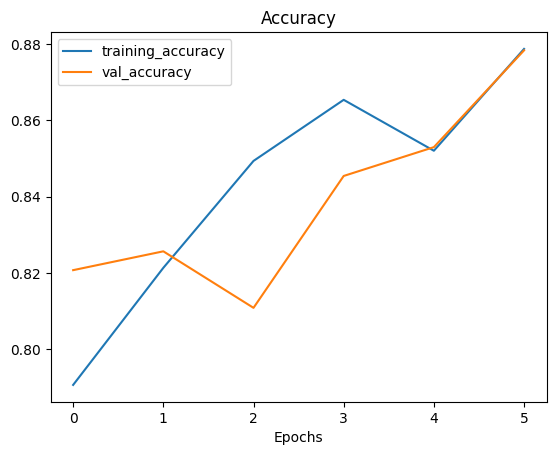

In [54]:
# Plot loss cureves.
plot_loss_curves(history_fine_10_percent_data_aug)

In [55]:
# Let's create a function to compare training histories.

def compare_history(original_history, new_history, initial_epochs=10):
  """
    Compares two TensorFlow History objectss
  """

  # Get original history measurements.
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']


  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  # Combine original history with new_history
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['accuracy']
  total_val_loss = val_acc + new_history.history['loss']


  # Make plots for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(total_val_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc="lower right")
  plt.title("Training and val accuracy")


  # Make plots for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label='Training loss')
  plt.plot(total_val_loss, label='Validation loss')
  plt.plot([initial_epochs-1, initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc="upper right")
  plt.title("Training and val loss")

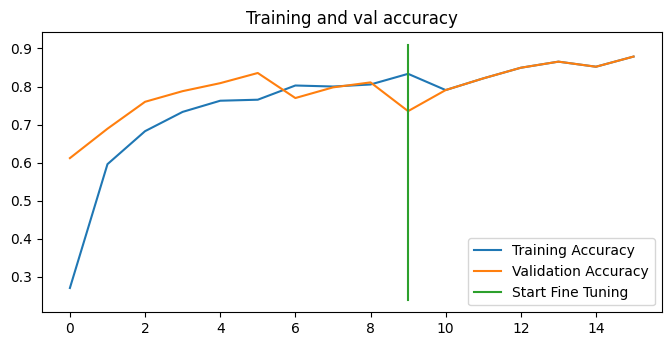

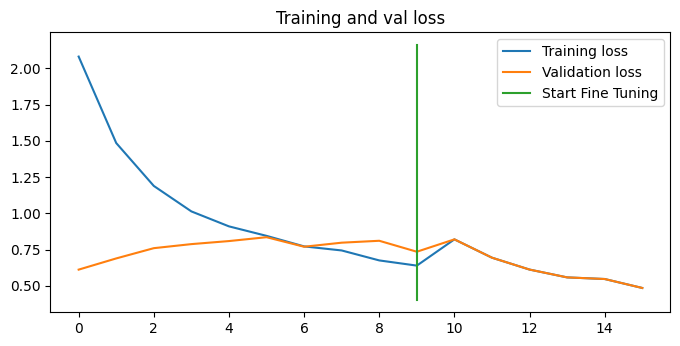

In [56]:
compare_history(history_model_2_10_percent_data_aug, history_fine_10_percent_data_aug)

## Model 4. Fine-tuning with all of our data

In [57]:
# Get the 100% of the data.

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

--2024-12-23 01:58:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.207, 74.125.143.207, 173.194.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.5’

10_food_classes_all 100%[===================>] 495.13M  39.6MB/s    in 13s     

2024-12-23 01:58:14 (38.2 MB/s) - ‘10_food_classes_all_data.zip.5’ saved [519183241/519183241]



In [58]:
# Setup training and test dir.
train_dir_all_data = "10_food_classes_all_data/train"
test_dir_all_data = "10_food_classes_all_data/test"

In [59]:
# How many images do we have ?.

walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data
There are 10 directories and 0 images in '10_food_classes_all_data/train
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream
There are 10 directorie

In [60]:
# Setup data inputs.

IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir_all_data,
    label_mode = "categorical",
    image_size = IMG_SIZE
)

test_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir_all_data,
    label_mode = "categorical",
    image_size = IMG_SIZE
)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [61]:
# Set up the last 10 layers of our base_model.trainable = True.

base_model.trainable = True

# Freeze all layers except for last 10.
for layer in base_model.layers[:-10]:
  layer.trainable = False


# Recompile (we have to recompile our models every time we change it layers)
model_2.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),   # When fine-tuning we lower the learning rate by 10x
    metrics = ['accuracy']
)

In [62]:
# Check which layers are trainable(tunable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer_2 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [63]:
# Checking the number of layers closer to the top with trainable variables...

print(len(model_2.trainable_variables))

12


### To trian a fine-tuning model(model_4) we need to revert model_2 back to its feature extraction weights. We do that by loading a weight(model) from checkpoint

In [64]:
 # Lets load model 2 from our checkpoint....
model_2.load_weights(checkpoint_filepath)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [65]:
# Lets evaluate model_2 now to see if it has been resetted.
model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.7692 - loss: 0.7940


[0.8052790760993958, 0.765999972820282]

All we have done is.

1. Train a feature extraction transfer learning for 5 epocs for 10% of the data with data augmentation (model_2) and we save the model weights using model's weights using 'modelCheckpoint' callback.

2. Fine-tuned the smae model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3)

3. Saved the results and training logs each time.

4. Reloaded the model from step 1 to do the same steps as 2 except this time we're going to use all of the data (model_4)

In [66]:
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [72]:
fine_tune_epochs = initial_epoch_value + 5

# Refit our model now with all the data.

history_fine_10_classes_full = model_2.fit(
    train_data_10_classes_full.repeat(),
    epochs = fine_tune_epochs,
    validation_data = test_data_10_classes_full,
    validation_steps = int(0.25 * len(test_data)),
    initial_epoch = history_fine_10_percent_data_aug.epoch[-1],   # We want to start from where we left off since we already started
    # initial_epoch=initial_epoch_value,  # Start from initial_epoch_value (10)
    steps_per_epoch = int(0.25 * len(test_data)),
    callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                             experiment_name="100_percent_fine_tune_last")]
)

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.8085 - loss: 0.6309 - val_accuracy: 0.8618 - val_loss: 0.4414


In [73]:
# Lets evaluate on all the data.

results_fine_tune_full_data = model_2.evaluate(test_data_10_classes_full)
results_fine_tune_full_data

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.8568 - loss: 0.4425


[0.4432913661003113, 0.86080002784729]

## Viewing our experiment data on TensorBoard.